In [58]:
import re
import random
import pandas as pd
import hashlib

In [59]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].mean() > 80: age_factor = .5
else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1/age_factor) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.05

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [60]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
C# Basics,104.867150,3.382811,14.453314,31
Azure Private DNS,439.054796,23.108147,51.198553,19
RAG Project,587.641435,36.727590,102.423437,16
Azure AD Authentication,774.420249,59.570788,167.753951,13
Azure Functions + Visual Studio,819.968635,63.074510,274.341396,13
Audit Report Tracker (Sharepoint List),878.086913,79.826083,255.087508,11
Email Auth and Security,894.421220,74.535102,172.820807,12
Open Source/GitHub,1079.393028,107.939303,340.150876,10
WSL + Kali Linux,1152.456154,82.318297,363.132709,14
Azure DevOps Pipelines,1262.702956,48.565498,96.717462,26


# Histogram

sum of ages: ~45701.46


<Axes: >

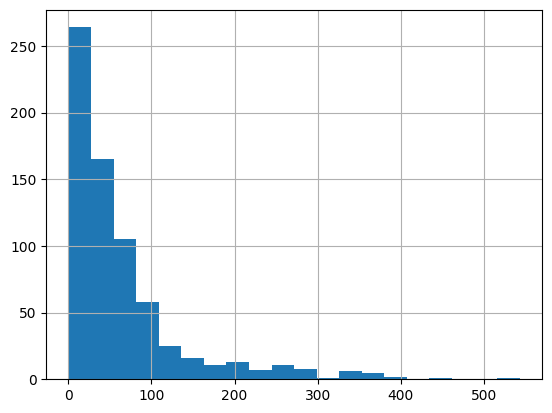

In [61]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [62]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [63]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [64]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

# Focus on one header

In [65]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Header with oldest cards first

In [66]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest mean card age first

In [67]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest age sum first

In [68]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [69]:
n=3
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

remake_card_document(existing_cards=existing_cards)
existing_cards.head(10)


Cards found: 699
Total card age: 45701.46


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
90,PnP PowerShell,AppInv.aspx\nA SharePoint page used to grant a...,ffb4c4ea52b6951b0ba17c6ec30a0956,-402.415902,70.009848,402.415902,-4970.699178,0.059753,0,0
561,PnP PowerShell,Document Library\nA SharePoint component where...,e7cb8946df57b531695ff6b9d7ed43ea,-253.611179,70.009848,402.415902,-4970.699178,0.059753,3,0
92,PnP PowerShell,Exponential Backoff\nA strategy for retrying f...,bdee8d2121190bd5691bcaf542e59869,-140.701459,70.009848,402.415902,-4970.699178,0.059753,6,0
93,PnP PowerShell,Update-PnPListItem (PnP.PowerShell)\nModifies ...,5ab02e03766613f079f802896014cfbf,-121.984155,70.009848,402.415902,-4970.699178,0.059753,9,0
94,PnP PowerShell,Get-MsalToken (MSAL.PS)\nRetrieves an OAuth 2....,a10ba617a3ae1b995eeca81f0e9abfe1,-102.306457,70.009848,402.415902,-4970.699178,0.059753,12,0
95,PnP PowerShell,Get-PnPGroup (PnP.PowerShell)\nRetrieves infor...,3fdbb114e57c98175fc1c57985709cf9,-86.097821,70.009848,402.415902,-4970.699178,0.059753,15,0
96,PnP PowerShell,AADSTS7000218 Error\nAn Azure AD error stating...,8d438f4a68d9dad39dccc2c2fbd10d43,-75.935063,70.009848,402.415902,-4970.699178,0.059753,18,0
97,PnP PowerShell,Write-Debug (Microsoft.PowerShell.Utility)\nOu...,5cc386284a4b178859c688e349922b89,-69.578256,70.009848,402.415902,-4970.699178,0.059753,21,0
569,PnP PowerShell,Connect-PnPOnline (PnP.PowerShell)\nEstablishe...,874a3f0f70df8de5e68fa8b5f2ba77b1,-60.962764,70.009848,402.415902,-4970.699178,0.059753,24,0
339,PnP PowerShell,Get-PnPList (PnP.PowerShell)\nRetrieves a Shar...,2997503edd622f398ca08b3707a18544,-57.337288,70.009848,402.415902,-4970.699178,0.059753,27,0


## Age Mean

In [70]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [71]:
# n = 4
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'age'], inplace=True)
## existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [72]:
# n=10
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'frequency', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [73]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [74]:
existing_cards.sort_values('age').head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
7,Logging in Python,Q: What is one of the main disadvantages of us...,3753dbeb5ebfb4e424ec2fccd2df3557,-542.804736,100.271777,542.804736,-2205.979100,0.910595,0,0
158,Vocab,"Lost in a Good Book\nDoric columns: A simple, ...",7f5496b30d95587923948c9509df2835,-445.998707,53.354459,445.998707,-4748.546824,0.071290,0,0
90,PnP PowerShell,AppInv.aspx\nA SharePoint page used to grant a...,ffb4c4ea52b6951b0ba17c6ec30a0956,-402.415902,70.009848,402.415902,-4970.699178,0.059753,0,0
31,Powershell Modules,CurrentUser Scope\n\nDefinition: An installati...,f3d0d03320782899e1352f748fc1cda5,-396.055470,93.077512,396.055470,-4095.410511,0.380521,0,0
331,PnP PowerShell,New-PnPList (PnP.PowerShell)\nCreates a new Sh...,9d9dc3700f5078d8eaff9507709eaacb,-364.463333,70.009848,402.415902,-4970.699178,0.059753,1,1
132,Azure Developer Associate,Name two ways to visualize Azure Monitor metri...,12019d06f3f283c2eb56ccc8c9ffc6a5,-363.934071,59.002549,363.934071,-4602.198801,0.855535,0,0
46,WSL + Kali Linux,WSLg (Windows Subsystem for Linux GUI)\nA feat...,69051af876862485bdb54d8c645a8a40,-363.132709,82.318297,363.132709,-1152.456154,0.626300,0,0
273,Powershell Modules,Auto-Import\n\nDefinition: A feature in PowerS...,6b1412630951dc5fee8ffa437ee0e0f2,-358.880117,93.077512,396.055470,-4095.410511,0.380521,1,1
15,Python,Q:\nWhich library is suggested for adding a pr...,20a08b1267d9ba7eb7b53e276cfdcc4c,-357.812088,96.607170,357.812088,-4540.537000,0.000616,0,0
62,JavaScript Concepts,Arrow Functions: Arrow functions provide a con...,2e3769781211a560564f81d13f2051b9,-348.254317,77.262814,348.254317,-4017.666344,0.281291,0,0


In [75]:
existing_cards.head(10).sum()

head                   PnP PowerShellPnP PowerShellPnP PowerShellPnP ...
body                   AppInv.aspx\nA SharePoint page used to grant a...
hash                   ffb4c4ea52b6951b0ba17c6ec30a0956e7cb8946df57b5...
age                                                         -1370.930345
subject_mean_age                                              700.098476
subject_highest_age                                          4024.159021
subject_age_sum                                            -49706.991781
head_random_roll                                                0.597525
count                                                                135
n_fold                                                                 0
dtype: object

In [76]:
existing_cards['age'].mean()

-65.38120277699666